In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import random
from matplotlib import animation
from matplotlib.animation import FuncAnimation
%matplotlib inline
from scipy.optimize import curve_fit
import matplotlib.pylab as pylab
from scipy.stats import iqr
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay
from collections import defaultdict
import itertools

In [249]:
def pb(x0,L):
    return((x0+L)%L)


class ant():

    def __init__(self,ids,flowc=0,stoppedc=0,cari=0):
        self.x=np.random.uniform(0,L)
        self.y=round(np.random.uniform(-1,1))*5        
        self.xunp=self.x
        self.v=np.random.uniform(0,1)
        self.dt=.05
        self.tau=.1
        #self.std=0
        self.v_pref=29#+min(np.random.normal(0,6.7),6.7)
        self.R=58
        self.r=4.5
        self.ids=ids
        self.stopped=0
        #print(cari)
        if (cari>=flowc):   
            #print(cari)
            self.v_pref=0  
            self.v=0
            self.stopped=1
                #print(stoppedc)
        self.ep=((self.v_pref)/self.tau)*(1-(self.r/self.R))**(-1.5)
        

  
    def step(self,x1=None,y1=None,vbar=0,counter=0):
        if (self.stopped==1):
            return
        fx=0
        fy=0
        x0=self.x
        y0=self.y
        r0=np.sqrt(x0**2+y0**2)
        r1=np.sqrt(x1**2+y1**2)
        fx=stepx(self.ep,self.R,x0,y0,x1,y1,L)        
        self.v=max(0,self.v+self.dt*((self.v_pref -self.v)/self.tau -fx))
        self.x=pb(self.x+self.dt*self.v,L)
        x0=self.x
        #r0=np.sqrt(x0**2+y0**2)
        #r1=np.sqrt(x1**2+y1*2)
        #dr=np.minimum(abs(r1-r0),L-abs(r1-r0))[0] #if any car is blocking, no lane change
        #if(dr<4.5):
        #    return #if any car is blocking, no lane change - return
        rand=np.random.uniform(-4.5,4.5)
        
        if(rand>0):#continuous lane change in +y
            w=np.where((np.minimum(abs(x1-x0),L-abs(x1-x0))<4.5) & (y1>y0))[0]  #y-blindsight
            y0=self.y+rand
            y0=min(y0,maxLy)
            if (len(w)>0):
                #print(rand)
                x11=x1[w]
                y11=y1[w]
                r0=np.sqrt(x0**2+y0*2)
                r11=np.sqrt(x11**2+y11**2)
                dr=min(np.sqrt((np.minimum(abs(x11-x0),L-abs(x11-x0))**2+(y11-y0)**2)))#if any car in the way of new change, no lane change
                if(dr<4.5):
                    return
            fx1=stepx(self.ep,self.R,x0,self.y,x1,y1,L) 
            fx2=stepx(self.ep,self.R,x0,y0,x1,y1,L)
            if (fx2<fx1): # accept lane change only if beneficial
                #print(rand)
                self.y=y0

        #print(rand)
        if(rand<0):#continuous lane change in +y
            w=np.where((np.minimum(abs(x1-x0),L-abs(x1-x0))<4.5) & (y1<y0))[0]
            y0=y0+rand
            y0=max(y0,minLy)
            #print(y0,self.y)
            #print(rand)
            if (len(w)>0):
                #print(rand)
                x12=x1[w]
                y12=y1[w]
                r0=np.sqrt(x0**2+y0*2)
                #r12=
                dr2=min(np.sqrt((np.minimum(abs(x12-x0),L-abs(x12-x0))**2+(y12-y0)**2)))
                if(dr2<4.5):
                    #print(rand)
                    return
            fx1=stepx(self.ep,self.R,x0,self.y,x1,y1,L) 
            fx2=stepx(self.ep,self.R,x0,y0,x1,y1,L)
            #print(fx2,fx1,self.x,self.y)
            #print(rand)
            #print(fx2,fx1)
            if (fx2<fx1):
                #print(rand)
                self.y=y0
        
def stepx(ep,R,x0,y0,x1,y1,L): #x direction force
    f=0
    r0=np.sqrt(x0**2+y0**2)
    r1=np.sqrt(x1**2+y1**2)
    #print(len(r1))
    w=np.where((y1<y0+4.5) & (y1>y0-4.5) & (x1!=x0))[0] # all cars in blindsight
    if (len(w)>0):
        #print(len(w))
        x01=x1[w]
        y01=y1[w]
        w=np.where((x01-x0>0) | (L+x01-x0<R))[0] # only cars in front (periodic bc)
        if (len(w)>0):
            #print(len(w))
            x01=x01[w]
            y01=y01[w]
            r01=np.sqrt(x01**2+y01*2)
            #dr=(np.minimum(abs(x01-x0),L-abs(x01-x0))) # minimum distance with only cars in front
            #print(len(dr))
            dr=min(np.sqrt((np.minimum(abs(x01-x0),L-abs(x01-x0))**2+(y01-y0)**2)))   
            #print(dr)
            #dr=np.min(abs(r1-r0))
            if(dr<R):
                f=ep*(1-(dr/R))**(1.5)
    return(f)
        
        

class ants():
    def __init__(self,num_ants=20,flowc=0,stoppedc=0):
        self.members=[ant(ids=i,flowc=flowc,stoppedc=stoppedc,cari=i) for i in range(num_ants)];
        self.statex=np.array([bug.x for bug in self.members])
        self.stopped=np.array([bug.stopped for bug in self.members])
        self.statey=np.array([bug.y for bug in self.members])
        self.xunp=np.array([bug.xunp for bug in self.members])
        self.vel=np.array([bug.v for bug in self.members])
        self.ids=np.array([i for i in range(num_ants)])
        self.vp=np.array([bug.v_pref for bug in self.members])
        self.members=sorted(self.members, key=lambda y: y.x)
        self.counter=0
        self.vbar=0
    def step(self):
        #meanvel=0
        for i,bug in enumerate(self.members):
            #x1=pb(self.statex,L)           
            #y1=pb(self.statey,15)           
            bug.step(self.statex,self.statey,self.vbar,self.counter)
#		print(self.counter)
        self.members=sorted(self.members,key=lambda y: y.x)
        self.statex=np.array([bug.x for bug in self.members])
        self.statey=np.array([bug.y for bug in self.members])
        self.xunp=np.array([bug.xunp for bug in self.members])
        self.vel=np.array([bug.v for bug in self.members])
        self.ids=np.array([bug.ids for bug in self.members])
        self.stopped=np.array([bug.stopped for bug in self.members])
        return(np.mean(self.vel))
#		self.vp=np.array([bug.v_pref for bug in self.members])
    def view(self,t):
        fig=plt.figure()
        plt.plot(my_ants.statex,my_ants.statey,'ro',markersize=7)
        w=np.where(my_ants.stopped==1)[0]
        plt.plot(my_ants.statex[w],my_ants.statey[w],'ko',markersize=7)
        plt.xlim(0,1000)
        plt.ylim(-50,50)
        fig.savefig('./images/graph'+str(t)+'.png') #save figures
        plt.close(fig)



def run():
    a1=0
#posn=np.zeros((1,3))
#dens2=np.zeros(10000)
#phi2=np.zeros(10000)
    for t in range(10000):
        meanv=my_ants.step()
#	a1=np.c_[my_ants.ids,my_ants.ids*0+t,my_ants.xunp]
#	posn=(np.r_[posn,a1])
        if ((t>9998)):
            mv.append(meanv)
        #if ((t%50==0)):

            #my_ants.view(t)
#		w=np.where((my_ants.state>500) &(my_ants.state<1000))[0]
#		dens2[t]=len(w)/500*1000
#		phi2[t]=np.sum(my_ants.vel[w])*3.6/(500/1000)
        #if t%1000==0:
        #    print(t)
#return (posn)


In [221]:
L=1000
maxLy=5
minLy=-5
rho_a=np.linspace(0.1,.1,1)
phi_a=np.zeros(1)
vel_a=np.zeros(1)
dens2_a=np.zeros(1)
for i,dens in enumerate(rho_a):
    print(i)
    mv=[]
    flowc=int(dens*L)   
    stopc=10
    num_ants=flowc+stopc
    my_ants=ants(num_ants=num_ants,flowc=flowc,stoppedc=stopc)
    run()
    phi_a[i]=dens*mv[-1]
    vel_a[i]=mv[-1]


0


/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:81: RuntimeWarning: invalid value encountered in sqrt
/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:111: RuntimeWarning: invalid value encountered in sqrt
/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:59: RuntimeWarning: invalid value encountered in sqrt


In [250]:
L=1000
rho_a=np.linspace(0.1,.1,1)
sc=np.array([1,5,10,20,30,50])
sc=sc*3
phi_a=np.zeros([6,100])
vel_a=np.zeros([6,100])
#vb2=np.zeros([15,10000])
for j in range(100):
    for i,stopc in enumerate(sc):
        #print(i)
        mv=[]
        flowc=int(rho_a*L)
        #print(flowc)
        stoppedc=stopc
        num_ants=stoppedc+flowc    
        my_ants=ants(num_ants=num_ants,flowc=flowc,stoppedc=stoppedc)
#	posn=np.zeros(num_ants)
        run()
        #print(i,j)
        phi_a[i,j]=rho_a*mv[-1]
        vel_a[i,j]=mv[-1]
    print(j)

/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:111: RuntimeWarning: invalid value encountered in sqrt
/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:59: RuntimeWarning: invalid value encountered in sqrt
/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:81: RuntimeWarning: invalid value encountered in sqrt


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73


KeyboardInterrupt: 

In [146]:
np.shape(sc)

(18,)

In [223]:
a=np.array([mv])
a=a[0]

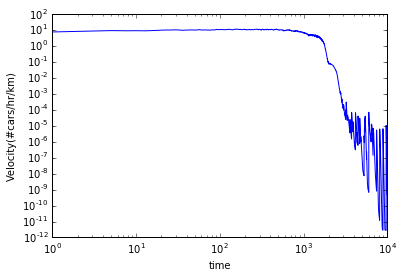

In [224]:
fig=plt.figure()
plt.loglog(a)

plt.xlabel('time')
plt.ylabel('Velocity(#cars/hr/km)')
#fig.savefig('Velocity-time-10stopcars_contlane.jpg',dpi=300)


In [261]:
rho_vel_phi_free100c_contlane_100it=np.c_[sc,vel_a[:,0:74],phi_a[:,0:74]]
rho_vel_phi_free100c_contlane_100it1=np.c_[sc,vel_a,phi_a]
np.savetxt('rho_vel_phi_free100c_contlane_100it.txt',rho_vel_phi_free100c_contlane_100it, fmt='%3.8f')
rho_vel_phi_free100c_contlane_100it=np.loadtxt('rho_vel_phi_free100c_contlane_100it.txt')

In [127]:
rho_ath=np.linspace(.001,.1,100)

/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app


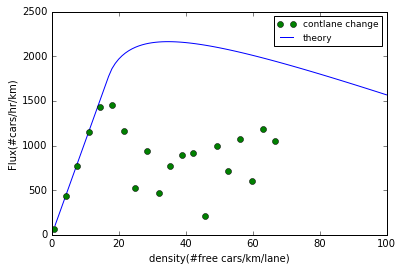

In [140]:
fig=plt.figure()
lth,=plt.plot(rho_ath*1000,rho_ath*1000*29*3.6-np.nan_to_num(rho_ath*1000*(29*3.6)*(1-(4.5/(2*29)))**(-1.5)*(1-1/(2*rho_ath*1000*.029))**(1.5)),label='theory')
l0,=plt.plot(rho_vel_phi_stop0car_contnl_2[:,0]*1000/3,rho_vel_phi_stop0car_contnl_2[:,2]*1000*3.6/3,'o',label='contlane change')
plt.legend(handles=[l0,lth],loc='best',prop={'size': 9})
plt.xlabel('density(#free cars/km/lane)')
plt.ylabel('Flux(#cars/hr/km)')
fig.savefig('Flux-density-0stopcars_contlane.jpg',dpi=300)


In [262]:
a1=np.array([-1,1,2,3,4])
a=np.zeros(1)
vel_a_1sc=rho_vel_phi_free100c_contlane_100it[0,1:75]
vel_a_5sc=rho_vel_phi_free100c_contlane_100it[1,1:75]
vel_a_10sc=rho_vel_phi_free100c_contlane_100it[2,1:75]
vel_a_20sc=rho_vel_phi_free100c_contlane_100it[3,1:75]
vel_a_30sc=rho_vel_phi_free100c_contlane_100it[4,1:75]
vel_a_50sc=rho_vel_phi_free100c_contlane_100it[5,1:75]


vel_a_1sc_mean=np.mean(vel_a_1sc)
vel_a_5sc_mean=np.mean(vel_a_5sc)
vel_a_10sc_mean=np.mean(vel_a_10sc)
vel_a_20sc_mean=np.mean(vel_a_20sc)
vel_a_30sc_mean=np.mean(vel_a_30sc)
vel_a_50sc_mean=np.mean(vel_a_50sc)

d=a1-a

In [265]:
np.shape(rho_vel_phi_free100c_contlane_100it)
74*2+1

149

In [266]:
prob_2f=np.zeros(6)
prob_20f=np.zeros(6)
prob_100f=np.zeros(6)

In [281]:
a1=vel_a_1sc
w=np.where(a1<1e-4)[0]
print(len(w)/74)

prob_2f[0]=0
prob_2f[1]=0.12
prob_2f[2]=0.49
prob_2f[3]=0.93
prob_2f[4]=0.99
prob_2f[5]=1.0

prob_20f[0]=0
prob_20f[1]=0.02
prob_20f[2]=0.3
prob_20f[3]=0.86
prob_20f[4]=1.0
prob_20f[5]=.99

prob_100f[0]=0.19
prob_100f[1]=0.82
prob_100f[2]=1.0
prob_100f[3]=1.0
prob_100f[4]=1.0
prob_100f[5]=1.0


0.1891891891891892


In [274]:
vel_a_50sc

array([  0.00000000e+00,   2.00000000e-08,   0.00000000e+00,
         0.00000000e+00,   1.80000000e-07,   0.00000000e+00,
         1.60000000e-07,   1.40000000e-07,   3.00000000e-08,
         1.50000000e-07,   1.00000000e-08,   3.00000000e-08,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.60000000e-07,   2.20000000e-07,
         8.00000000e-08,   2.00000000e-08,   1.00000000e-08,
         4.00000000e-08,   5.00000000e-08,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         2.12000000e-06,   1.70000000e-07,   0.00000000e+00,
         0.00000000e+00,   3.56000000e-06,   3.50000000e-07,
         4.00000000e-08,   0.00000000e+00,   4.70000000e-07,
         2.23000000e-06,   1.33000000e-06,   1.70000000e-07,
         1.50000000e-07,   0.00000000e+00,   0.00000000e+00,
         1.41000000e-06,   3.10000000e-07,   1.37000000e-06,
         7.00000000e-08,   0.00000000e+00,   2.94000000e-06,
         0.00000000e+00,

In [178]:
data=np.zeros([1000,60])

for it in range(0,1000):
    for i in range(0,60):
        xpos1=np.random.uniform(0,1000,i+1)
        xpos2=np.random.uniform(0,1000,i+1)
        xpos3=np.random.uniform(0,1000,i+1)
        c=0
        for j in range(0,i):
            w2=np.where((xpos2>xpos1[j]-4.5) & (xpos2<xpos1[j]+4.5))[0]
            x2=xpos2[w2]
            for k in range(0,len(w2)):
                w3=np.where((xpos3>x2[k]-4.5) & (xpos3<x2[k]+4.5))[0]
                c=c+len(w3)
            #c=c+(min(len(w3),len(w2))>0)*1                     
            #c=c+len(w)
        data[it,i]=(c>0)*1
    print(it)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

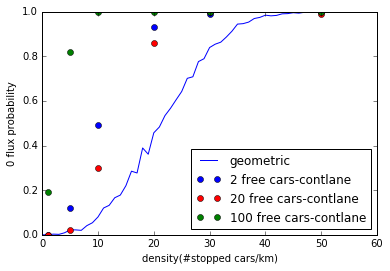

In [287]:
fig=plt.figure()
l1,=plt.plot(np.arange(60),(np.sum(data,axis=0))/1000,label='geometric')
#plt.plot(rho_sc,prob,'bo')
#l1,=plt.plot(rho_sc,prob,'ro',label='averaged free cars')
l2,=plt.plot(sc/3,prob_2f,'bo',label='2 free cars-contlane')
plt.xlim(0,60)
plt.xlabel('density(#stopped cars/km)')
plt.ylabel('0 flux probability')
l3,=plt.plot(sc/3,prob_20f,'ro',label='20 free cars-contlane')
l4,=plt.plot(sc/3,prob_100f,'go',label='100 free cars-contlane')
plt.legend(handles=[l1,l2,l3,l4],loc='best')

fig.savefig('Percolation-density-free-theory-contlanes3.jpg',dpi=300)


In [246]:
vel_a_50sc

array([  0.00000000e+00,   1.00000000e-08,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.00000000e-08,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.38000000e-06,   0.00000000e+00,   0.00000000e+00,
         8.00000000e-08,   5.37000000e-06,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.00000000e-08,   0.00000000e+00,   0.00000000e+00,
         1.22500000e-05,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         3.70000000e-07,   0.00000000e+00,   1.00000000e-07,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         2.00000000e-08,   4.00000000e-08,   0.00000000e+00,
         1.00000000e-08,